# Introducción a los autoencodificadores


## Aprendizaje supervisado y no supervisado


### Aprendizaje supervisado


En los cursos anteriores, solo hemos abordado casos de aprendizaje supervisado. Básicamente, se trata de situaciones en las que los datos de entrenamiento contienen tanto una entrada **x** como una salida **y**. El modelo debe tomar **x** como entrada y predecir **y**.
Por ejemplo, en MNIST, teníamos una imagen **x** y una etiqueta **y** que representaba un dígito entre 0 y 9. En segmentación, utilizábamos una imagen **x** y una máscara **y** como salida.


### Aprendizaje no supervisado


En el aprendizaje no supervisado, los datos no están etiquetados, lo que significa que solo tenemos **x** sin **y**. En este caso, no podemos predecir un valor exacto, pero sí entrenar un modelo para agrupar elementos similares (esto se conoce como *clustering*).
En este curso, nos centraremos en la **detección de anomalías no supervisada**. La idea es entrenar un modelo con un tipo específico de datos y luego usarlo para detectar elementos que difieran del conjunto de entrenamiento.


## Autoencodificador


### Arquitectura


El modelo base para este tipo de tareas se denomina **autoencodificador**. Su arquitectura se asemeja a la del U-Net que vimos anteriormente.
A continuación, se muestra la arquitectura clásica de un autoencodificador:


Como puedes observar, tiene una forma de "reloj de arena". La idea del autoencodificador es generar una representación comprimida de los datos de entrada y reconstruirlos a partir de esta. Además, este modelo también puede utilizarse para comprimir datos.


### Uso en la detección de anomalías no supervisada


Para la detección de anomalías no supervisada, tomemos un ejemplo. Entrenamos el autoencodificador para reconstruir imágenes del dígito **5**. Una vez entrenado, reconstruirá perfectamente las imágenes de **5**. Si queremos detectar si una imagen es un **5** u otro dígito, simplemente la pasamos al autoencodificador. Al analizar la calidad de la reconstrucción ($imagen_{original} - imagen_{reconstruida}$), podemos determinar si se trata de un **5** o no.
La siguiente imagen ilustra este principio:


## Aplicación práctica con MNIST


Para ilustrar lo descrito, entrenaremos un autoencodificador para reconstruir el dígito **5** usando PyTorch.


In [14]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

### Creación de los conjuntos de datos de entrenamiento y prueba


In [15]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

Hemos obtenido nuestros conjuntos de datos de entrenamiento/validación y prueba. Queremos conservar solo los dígitos **5** en el conjunto de entrenamiento. Para ello, eliminamos los elementos que no contengan el número **5**.


In [16]:
# On récupere les indices des images de 5
indices = [i for i, label in enumerate(dataset.targets) if label == 5]
# On créer un nouveau dataset avec uniquement les 5
filtered_dataset = torch.utils.data.Subset(dataset, indices)

Podemos visualizar algunas imágenes para confirmar que solo tenemos dígitos **5**.


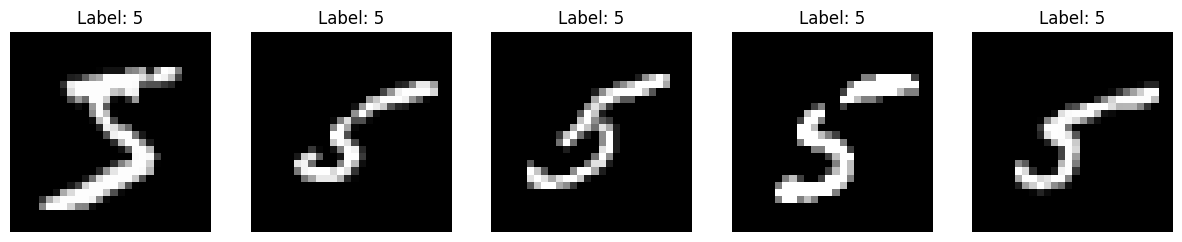

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  image, label = filtered_dataset[i]
  image = image.squeeze().numpy() 
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f'Label: {label}')
  axes[i].axis('off')
plt.show()

Ahora dividimos el conjunto de datos en partes de entrenamiento y validación, y luego creamos nuestros *dataloaders*.


In [18]:
train_dataset, validation_dataset=torch.utils.data.random_split(filtered_dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Creación del modelo autoencodificador


Para el conjunto de datos MNIST, una arquitectura poco profunda es suficiente para obtener buenos resultados.


In [19]:
class ae(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
      nn.Linear(28 * 28, 512), 
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
    )
    self.decoder = nn.Sequential(
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 28 * 28),
      nn.Sigmoid()
    )
  
  def forward(self,x):
    x=x.view(-1,28*28) 
    x = self.encoder(x)
    x = self.decoder(x)
    recons=x.view(-1,28,28)
    return recons

In [20]:
model = ae()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

ae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Nombre de paramètres 1132944


### Entrenamiento del modelo


Para la función de pérdida, utilizamos **MSELoss**, que corresponde al error cuadrático medio definido por:
$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
donde $N$ es el número total de píxeles en la imagen, $y_i$ es el valor del píxel $i$ en la imagen original y $\hat{y}_i$ es el valor del píxel $i$ en la imagen reconstruida.
Esta es una función clásica para evaluar la calidad de una reconstrucción.


In [21]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
for i in range(epochs):
  loss_train=0
  for images, _ in train_loader:
    recons=model(images)
    loss=criterion(recons,images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, _ in val_loader:
    with torch.no_grad():
      recons=model(images)
      loss=criterion(recons,images)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.08228749781847
step 0 val loss 0.06261523813009262
step 1 train loss 0.06122465804219246
step 1 val loss 0.06214689463376999
step 2 train loss 0.06105153635144234
step 2 val loss 0.06189680099487305
step 3 train loss 0.06086035445332527
step 3 val loss 0.06180128455162048
step 4 train loss 0.0608210563659668
step 4 val loss 0.06169722229242325
step 5 train loss 0.06080913543701172
step 5 val loss 0.061976321041584015
step 6 train loss 0.060783520340919495
step 6 val loss 0.06190618872642517
step 7 train loss 0.06072703003883362
step 7 val loss 0.06161761283874512
step 8 train loss 0.06068740040063858
step 8 val loss 0.061624933034181595
step 9 train loss 0.060728199779987335
step 9 val loss 0.061608292162418365


Ahora observemos la reconstrucción de las imágenes del conjunto de prueba.


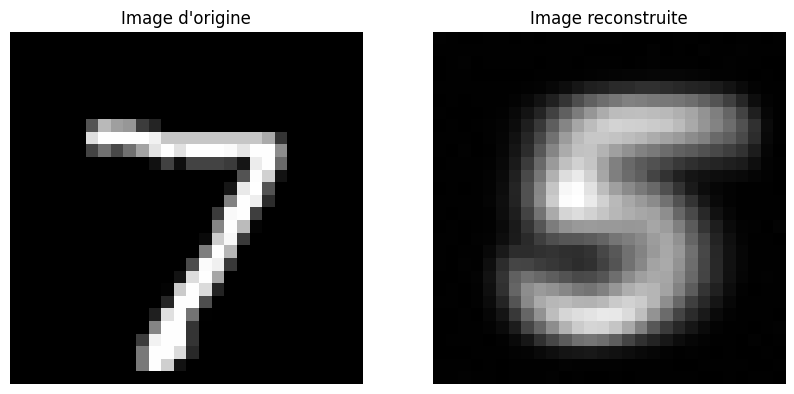

difference :  0.0687035545706749


In [23]:
images,_=next(iter(test_loader))

#Isolons un élément 
image=images[0].unsqueeze(0)
with torch.no_grad():
  recons=model(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image d'origine
axs[0].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Image d\'origine')
axs[0].axis('off')

# Image reconstruite
axs[1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
axs[1].set_title('Image reconstruite')
axs[1].axis('off')
plt.show()
print("difference : ", criterion(image,recons).item())

Observamos que la reconstrucción del dígito **7** es muy deficiente, lo que nos permite deducir que se trata de una anomalía.
